In [1]:
import numpy as np
import matplotlib.pyplot as plt
import load_data
import pathlib

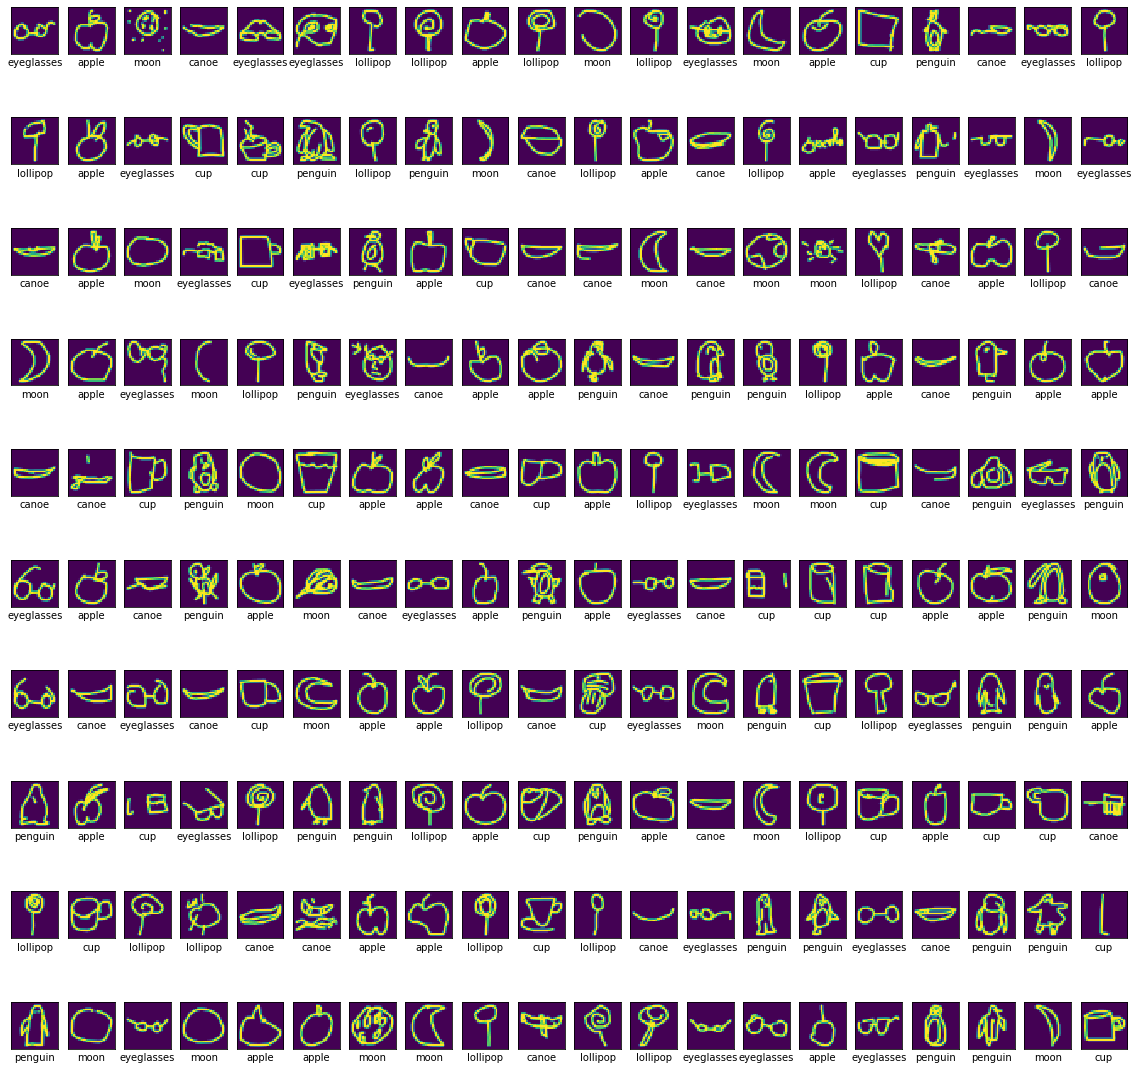

In [5]:
subset = np.random.choice(range(len(input_test)), size=200, replace=False)

plt.figure(figsize=(20, 20))
for i in range(200):
    plt.subplot(10, 20, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_test[subset[i]].reshape(28,28))
    plt.xlabel(d_i[np.argmax(target_test[subset[i]])])
plt.show()

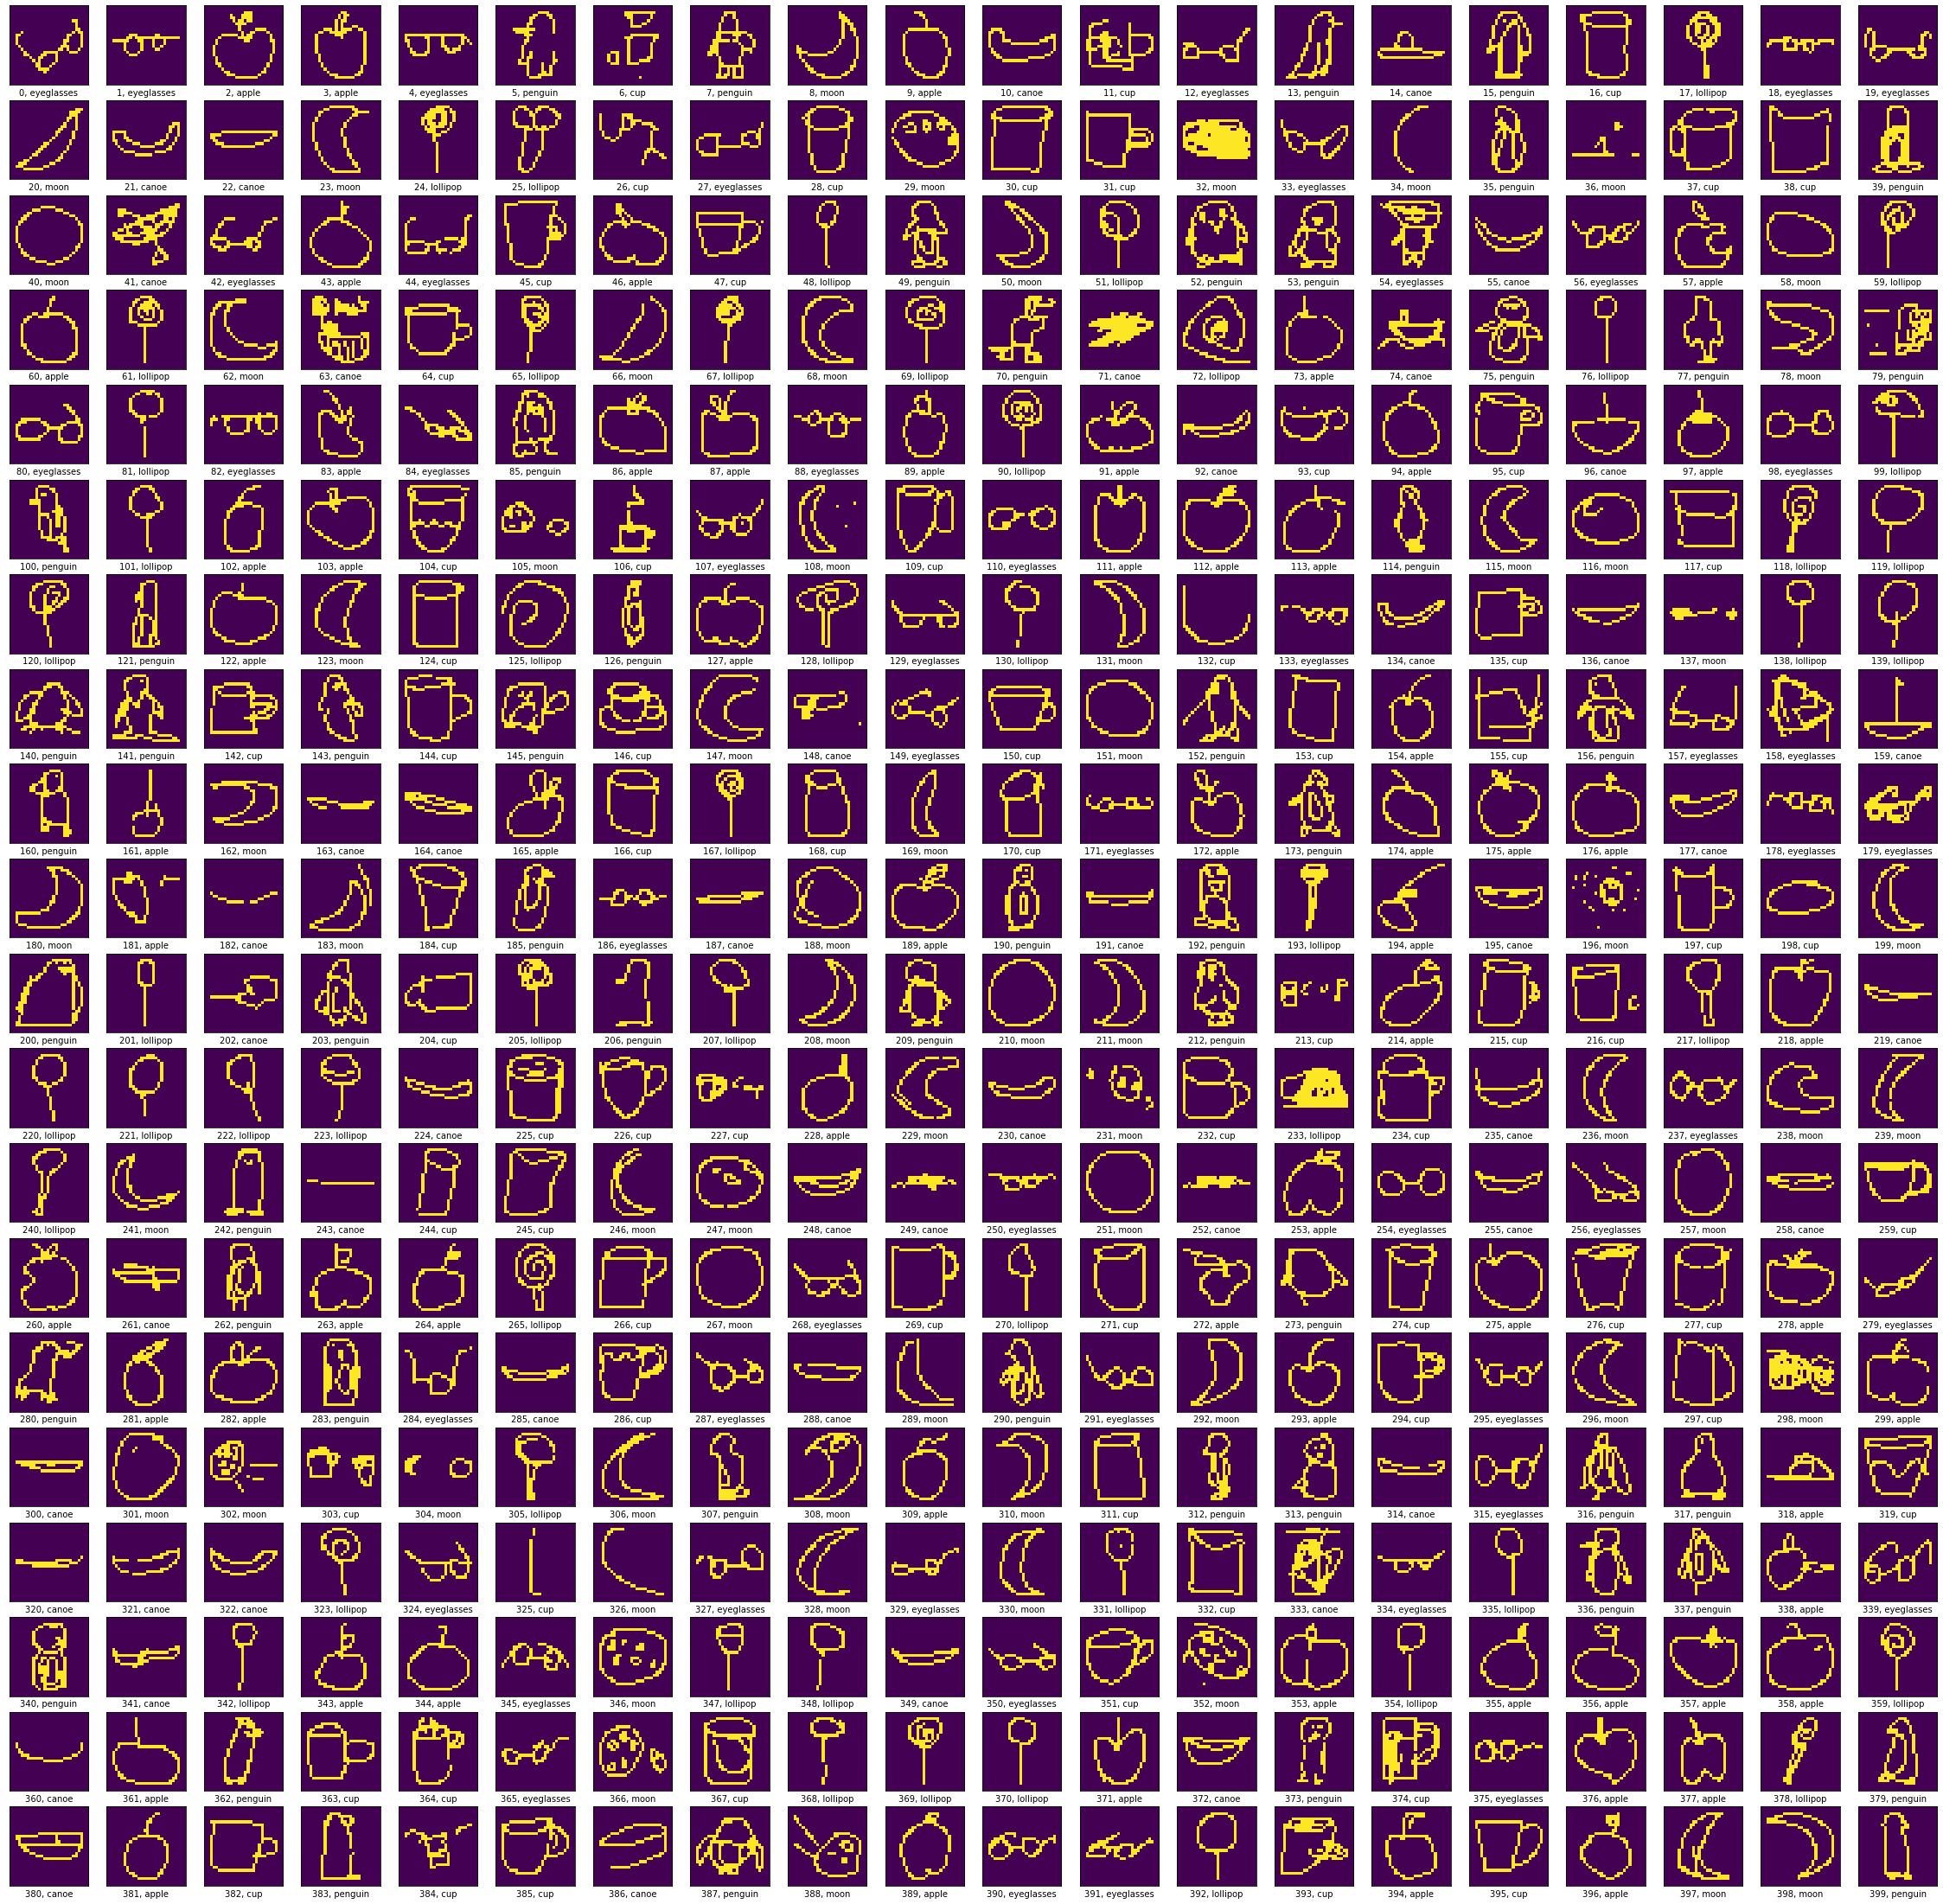

In [6]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import load_data
import pathlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}

num_channels = 1
input_shape = (28, 28, num_channels)
latent_dim = 14

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)
conv_shape = K.int_shape(cx)

def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

encoder = Model(i, [mu, sigma, z], name='encoder')

d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
decoder = Model(d_i, o, name='decoder')

# Output encoder, decoder, CVAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')

def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    img_width = 28
    img_height = 28
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

class CVAE_tester:
    def __init__(self, model_path, test_set, pretrained_classifier):
        self.model = tf.keras.models.load_model(model_path, compile=False)
        self.model.compile(loss=kl_reconstruction_loss)
        self.classifier = tf.keras.models.load_model(pretrained_classifier)
        self.test, self.labels = test_set
        self.N = len(self.labels)
        self.d_i = {0:"lollipop", 1:"canoe", 2:"penguin", 3:"eyeglasses", 4:"apple", 5:"moon", 6:"cup"}
    
    def gen_array(self, n):
        indices = np.random.choice(range(len(self.test)), n * n, replace=False)
        plt.figure(figsize=(2 * n, 2 * n))
        for i in range(n * n):
            plt.subplot(n, n, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(self.test[indices[i ]].reshape(28,28))
            plt.xlabel(str(i) + ", " + self.d_i[np.argmax(self.labels[indices[i ]])])
        plt.show()
   
dim_old = 28
dat_path = pathlib.Path('object_files/').glob('*.npz')
input_train, target_train, _, _, input_test, target_test = load_data.load_for_cnn(dat_path, 
                                                                                  dim_old, d, (0.7, 0.01), 
                                                                                  channel_axes=1, 
                                                                                  dim_new=None, 
                                                                                  binary=True)

tester = CVAE_tester('cvae_128256_ld_14_new/vae', (input_test, target_test), 'saved_models/VGG_model')
tester.gen_array(20)
